In [1]:
import numpy as np
import matplotlib.pyplot as plt
from diskmodels import profilecirc
from diskfit import likelihood, utils
from scipy.optimize import minimize
import emcee

z = 0.0146
cont = np.array([-2.57426216e-06, -4.41129826e+00,  8.08577702e-16])

#### Functions

In [2]:
def power_law(wl, A, k, C):
    return A*(wl/(1+z))**k+C

def model_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, w, y, yerr, lines, linesbroad, fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    ampsbroad = [params['broadHalphaflux']]
    lineprofsbroad = utils.build_line_profiles(x,linesbroad,params['broadwidth'])   
    broadmodel = lineprofsbroad[0] * ampsbroad[0]
    for line,amp in zip(lineprofsbroad[1:],ampsbroad[1:]):
        narrowmodel1+=line*amp 
    model = np.sum((diskout,narrowmodel,broadmodel),axis=0)
    return model

def plot_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, w, y, yerr, lines, linesbroad,fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    ampsbroad = [params['broadHalphaflux']]
    lineprofsbroad = utils.build_line_profiles(x,linesbroad,params['broadwidth'])   
    broadmodel = lineprofsbroad[0] * ampsbroad[0]
    for line,amp in zip(lineprofsbroad[1:],ampsbroad[1:]):
        narrowmodel1+=line*amp 
    model = np.sum((diskout,narrowmodel,broadmodel),axis=0)

    return diskout,narrowmodel,broadmodel

class log_prior(object):
    def __init__(self, mins, maxes):
        self.mins = mins
        self.maxes = maxes
    def __call__(self, theta): 
        if np.any(theta<self.mins) or np.any(theta>self.maxes): 
            return -np.inf
        return 0.0 

class logprob_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(object):
    def __init__(self, x, y, yerr, lines, linesbroad, fixed, fitted, mins, maxes): 
        self.x = x
        self.y = y
        self.yerr = yerr
        self.lines = lines
        self.linesbroad = linesbroad
        self.fixed = fixed
        self.fitted = fitted
        self.mins = mins
        self.maxes = maxes
        self.log_prior = log_prior(self.mins, self.maxes)
    def __call__(self,theta):
        lp = self.log_prior(theta)
        like = loglikelihood_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.linesbroad,self.fixed, self.fitted)
        if np.any(np.isnan(like)):
            #return np.full(len(like),1e10+lp)
            return -np.inf   
        #print(like,lp)
        return like+lp 
    def test(self,theta):
        modelout = model_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.linesbroad, self.fixed, self.fitted) 
        return modelout 
    def plot(self,theta):
        diskout,narrowout, broadout = plot_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, self.x, self.y, self.yerr, self.lines, self.linesbroad, self.fixed, self.fitted) 
        return diskout,narrowout,broadout

def loglikelihood_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(theta, w, y, yerr, lines, linesbroad,fixed, fitted):
    fitted = dict(zip(fitted.keys(),theta)) 
    params = {**fitted, **fixed}
    x = w/(1+params['z'])
    xib0 = (params['xi2']-params['xi1'])*params['xib']+params['xi1'] 
    diskmodel = profilecirc.profile(params['maxstep'],params['xi1'],params['xi2'],params['broad'],params['q1'],params['q2'],xib0,params['angi']%180,params['anglam'],params['t0'],params['eta'],params['version'],params['amp'],params['narms'],params['aobs']%360,params['pitch'],params['width'],params['xispin'],params['xispout'],params['nstep'],params['relativistic'],params['olambda'],params['npix'],x)
    widths = np.hstack((np.ones(len(lines))*params['narrowwidth'],np.ones(len(lines))*params['narrowwidth2'])) 
    lineprofs1 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[:len(lines)],params['ratios'])   
    lineprofs2 = utils.build_doublet_profiles(x,lines[:len(lines)],widths[len(lines):2*len(lines)],params['ratios'])    
    amps = [params['Halphaflux'],params['NIIbflux'],params['SIIbflux']]
    narrowmodel1 = lineprofs1[0] * amps[0]
    for line,amp in zip(lineprofs1[1:],amps[1:]):
        narrowmodel1+=line*amp 
    narrowmodel2 = lineprofs2[0] * amps[0]
    for line,amp in zip(lineprofs2[1:],amps[1:]):
        narrowmodel2+=line*amp 
    narrowmodel = np.sum((narrowmodel1,narrowmodel2),axis=0)
    diskout = diskmodel*params['diskflux']
    ampsbroad = [params['broadHalphaflux']]
    lineprofsbroad = utils.build_line_profiles(x,linesbroad,params['broadwidth'])   
    broadmodel = lineprofsbroad[0] * ampsbroad[0]
    for line,amp in zip(lineprofsbroad[1:],ampsbroad[1:]):
        narrowmodel1+=line*amp 
    model = np.sum((diskout,narrowmodel,broadmodel),axis=0) 
    sigma2 = yerr**2  
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

#### Spec

In [3]:
wl, flux = np.loadtxt('E1spec.txt', unpack=True)
flux -= 7.25e-16
flux *= 1e17

olambda = 6563
wavemin = 6250
wavemax = 6900
wave = wl/(1+z)
indwave = np.argwhere((wave>wavemin)&(wave<wavemax)&~np.isnan(flux))[:,0]
wl = np.asarray(wl[indwave],dtype=np.float64)
fluxerr = np.ones(flux.shape)*np.median(np.abs(flux[1:]-flux[:-1]))
flux = flux[indwave]
fluxerr = 3*fluxerr[indwave]
npix = wl.shape[0]

In [4]:
# Integration, units, normalization
maxstep = 400 # Maximum number of integration steps (integer)
nstep = 100 # integration steps (integer, </= 400)
relativistic = 'y' #  include relativistic effects? (y/n) [y]
normalization = 'max' # profile normalization scheme (max/flux/none) [max]

# Circular disk size and emission properties
q1 = 1.9 #inner emissivity powerlaw index
q2 = 1.9 #outer emissivity powerlaw index
xib = 0.6 #power-law index break radius (XIB=0 causes Q=Q2 throughout)

# Wind properties
t0 = 1e-8   # optical depth normalization (0=no wind)
eta = 0.8 #optical depth power-law index
anglam = 8 #wind opening angle (degrees)
version = 'f' #formula for escape probability (f=Flohic, m=Murray)

# Spiral arms
narms = 1 #number of arms (integer)
pitch = -20 #pitch angle of spiral pattern (+ve=leading, -ve=trailing)
width = 40 #angular width of arm (degrees)
xispin = 1000 #inner spiral arm radius radius (GM/c^2, 0=XI1)
xispout = 2000 #outer spiral arm radius radius (GM/c^2, 0=XI2)

# Narrow lines
narrowwidth = 1.7 # Width of component 1 of broad line in Angstroms
narrowwidth2 = 0.9 # Width of component 2 of broad line in Angstroms
narrowfrac = 0.2 #Amplitude fraction the two narrow line components

In [5]:
angimin, angimax = -360, 360
xi1min, xi1max = 50, 10000
xi2min, xi2max = 100, 25000
broadmin, broadmax = 0, 2000
ampmin, ampmax = -1e-12, 5.0
pitchmin, pitchmax = -60, 60
aobsmin, aobsmax = -720, 360*3
narrowwidthmin, narrowwidthmax = 0.1, 15.0
narrowwidth2min, narrowwidth2max = 0.1, 12.0
narrowfracmin, narrowfracmax = 0.1, 5.0
anglammin, anglammax = 2.0, 40
t0min, t0max = 1e-10, 1e2
etamin, etamax = -1.5, 1.5
Halphafluxmin, Halphafluxmax = 5, 300
NIIbfluxmin, NIIbfluxmax = 0.0, 8
SIIbfluxmin, SIIbfluxmax = 0.0, 300
diskfluxmin, diskfluxmax = 1, 500

broadwidthmin, broadwidthmax = 20, 500
broadHalphafluxmin, broadHalphafluxmax = 0.0, 300

diskmins = [
xi1min,xi2min,broadmin,angimin,broadwidthmin,broadHalphafluxmin,narrowfracmin,narrowwidthmin,narrowwidth2min,anglammin,t0min,etamin,Halphafluxmin,NIIbfluxmin,diskfluxmin,ampmin,aobsmin]
diskmax = [
xi1max,xi2max,broadmax,angimax,broadwidthmax,broadHalphafluxmax,narrowfracmax,narrowwidthmax,narrowwidth2max,anglammax,t0max,etamax,Halphafluxmax,NIIbfluxmax,diskfluxmax,ampmax,aobsmax]

In [6]:
NIIa = 6549.86
Halpha = 6564.614
NIIb = 6585.27
SIIa = 6718.29
SIIb = 6732.68
lines = [Halpha,NIIa,NIIb,SIIa,SIIb]
linesbroad = [6590]
NIIb_NIIa = 2.95
SIIb_SIIa = 1.3
ratios = [NIIb_NIIa,SIIb_SIIa]
Halphaflux = 8
NIIbflux = 2.5
diskflux = 4
SIIbflux = 0

In [7]:
angi = 10 #disk inclination angle (degrees)
xi1 = 1000 #inner disk radius (GM/c^2)
xi2 = 2000 #outer disk radius (multiple of xi1)
broad = 1000 #broadening parameter (km/s)

amp  = 1
aobs = 270

# Broad component
broadwidth = 90
broadHalphaflux = 20

fitted_labels = ['xi1','xi2','broad','angi','broadwidth','broadHalphaflux','narrowfrac','narrowwidth','narrowwidth2','anglam','t0','eta','Halphaflux','NIIbflux','diskflux','amp','aobs']
initial = [xi1,xi2,broad,angi,broadwidth,broadHalphaflux,narrowfrac,narrowwidth,narrowwidth2,anglam,t0,eta,Halphaflux,NIIbflux,diskflux,amp,aobs]

fitted = dict(zip(fitted_labels,initial))

fixed_labels = ['z','ratios','q1','q2','xib','maxstep','version','narms','pitch','width','xispin','xispout','nstep','relativistic','olambda','npix','SIIbflux']
fixed_values = [z,ratios,q1,q2,xib,maxstep,version,narms,pitch,width,xispin,xispout,nstep,relativistic,olambda,npix,SIIbflux]
fixed = dict(zip(fixed_labels,fixed_values))

In [8]:
modelguess = model_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(initial, wl, flux, fluxerr, lines, linesbroad, fixed, fitted)
disk,narrowlines,broadlines= plot_linefit_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(initial, wl, flux, fluxerr, lines, linesbroad, fixed, fitted)

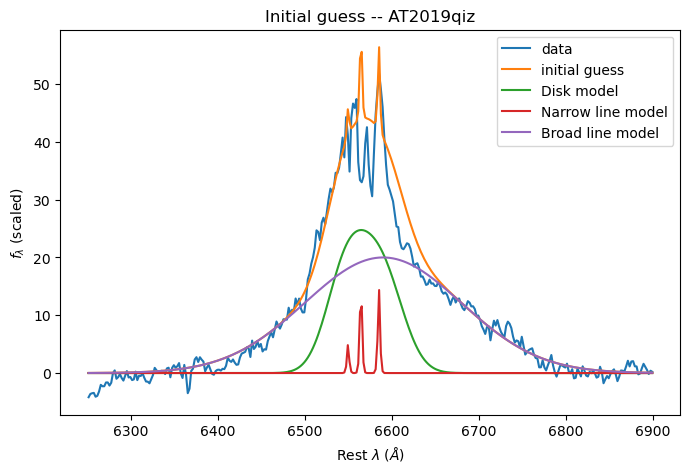

In [9]:
plt.figure(figsize=(8,5))
plt.plot(wl/(1+fixed['z']),flux,label='data')
plt.plot(wl/(1+fixed['z']),modelguess,label='initial guess')
plt.plot(wl/(1+fixed['z']),disk,label='Disk model')
plt.plot(wl/(1+fixed['z']),narrowlines,label='Narrow line model')
plt.plot(wl/(1+fixed['z']),broadlines,label='Broad line model')
#plt.axvline(6582); plt.axvline(6588)
plt.xlabel('Rest $\lambda$ ($\AA$)'); plt.ylabel('$f_{\lambda}$ (scaled)')
plt.title('Initial guess -- AT2019qiz'); plt.legend(); plt.show()

In [10]:
lp = logprob_circ_fixeddoublet_freeamplitudes_addbroadline_Halpha(wl, flux, fluxerr, lines, linesbroad, fixed, fitted, diskmins, diskmax)

In [11]:
nll = lambda *args: -lp(*args)
soln = minimize(nll, initial, method='Nelder-Mead')
modelfit = lp.test(soln.x)

print('Best-fit parameter values:', soln.x)

Best-fit parameter values: [1.27616770e+03 2.51481094e+03 8.07934258e+02 1.30448043e+01
 9.73987645e+01 1.73189351e+01 2.07075746e-01 3.13623205e+00
 1.96679014e-01 9.98472069e+00 7.37453390e-09 4.67384824e-01
 5.00092678e+00 3.04070926e+00 4.65430546e+00 1.17172618e+00
 2.13982996e+02]


xi1,xi2,broad,angi, <br>
broadwidth,broadHalphaflux,narrowfrac,narrowwidth, <br>
narrowwidth2,anglam,t0,eta, <br>
Halphaflux,NIIbflux,diskflux,amp,aobs <br>

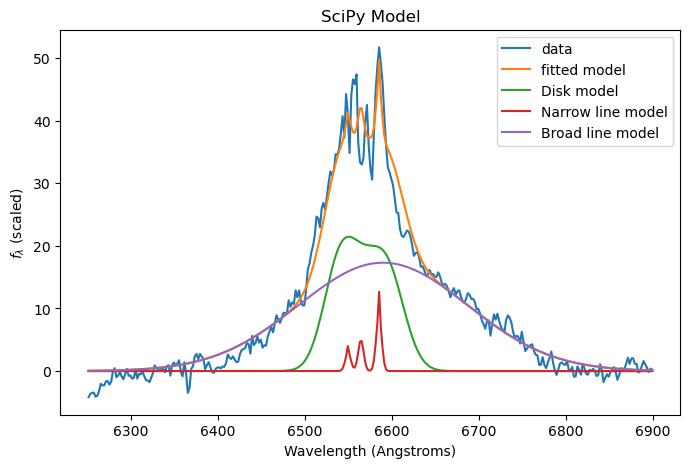

In [12]:
disk,narrowlines,broadlines = lp.plot(soln.x)
plt.figure(figsize=(8,5))
plt.plot(wl/(1+fixed['z']),flux,label='data')
plt.plot(wl/(1+fixed['z']),modelfit,label='fitted model')
plt.plot(wl/(1+fixed['z']),disk,label='Disk model')
plt.plot(wl/(1+fixed['z']),narrowlines,label='Narrow line model')
plt.plot(wl/(1+fixed['z']),broadlines,label='Broad line model')
plt.xlabel('Wavelength (Angstroms)'); plt.ylabel('$f_{\lambda}$ (scaled)')
plt.title('SciPy Model'); plt.legend(); plt.show()

In [13]:
pos = soln.x + 5e-1 * soln.x * np.random.randn(50, soln.x.shape[0])
nwalkers, ndim = pos.shape
filename ='emcee.h5'
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
        nwalkers, ndim, lp, args=(), backend=backend
    )
sampler.run_mcmc(pos, 10000, progress=True)

  0%|          | 0/10000 [00:00<?, ?it/s]/home/at4206/.conda/envs/Diskfit/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  4%|▎         | 371/10000 [38:57<16:50:03,  6.29s/it]/tmp/ipykernel_1339846/857628735.py:118: RuntimeWarning: overflow encountered in square
  return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
 35%|███▌      | 3548/10000 [5:51:26<10:17:35,  5.74s/it]/home/at4206/.conda/envs/Diskfit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
100%|██████████| 10000/10000 [16:32:11<00:00,  5.95s/it] 


State([[ 1.34368014e+03  1.96084773e+03  7.97206278e+02  1.28374812e+01
   9.21993013e+01  1.77824497e+01  3.79597553e+00  5.79055242e+00
   1.28476386e-01  3.89769568e+01  2.00601094e-08 -1.27066023e+00
   8.93149958e+00  6.01821684e+00  5.69783047e+00  4.01215701e+00
   2.55347800e+02]
 [ 6.84028822e+03  2.21866500e+04  7.30391160e+02  3.82353458e+01
   9.27663042e+01  1.81506502e+01  3.18220041e+00  5.09828242e+00
   4.14751488e-01  3.52045567e+01  5.15159646e-07 -1.48668175e+00
   5.50953229e+00  3.63803483e+00  2.50619210e+00  2.80918414e+00
  -4.16594125e+02]
 [ 9.63873800e+03  1.65896038e+04  8.61414143e+02  4.48733052e+01
   9.26892478e+01  1.70500737e+01  2.37262047e+00  4.93978786e+00
   1.44796438e-01  1.19416930e+01  9.56740422e-07 -1.14429465e+00
   7.02946906e+00  5.85990671e+00  5.05752932e+00  1.32084340e+00
  -2.09471426e+02]
 [ 8.00842571e+03  1.95428090e+04  7.62524645e+02  3.61009403e+01
   9.38754802e+01  1.77624653e+01  7.16840214e-01  5.02305221e+00
   1.25094740